In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

In [2]:
def download_and_unzip_spam_data(
    url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download "
            "and extraction."
        )
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


#### Load into a Pandas DF

In [3]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


#### Examine value distribution

In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


There is a class inbalance. For ease, we will keep a 50:50 class-split

In [5]:
def create_balanced_dataset(df):
    spam_df = df[df["Label"] == "spam"]
    ham_df = df[df["Label"] == "ham"].sample(n=len(spam_df), random_state=123)
    balanced_df = pd.concat([spam_df, ham_df])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
spam    747
ham     747
Name: count, dtype: int64


Map labels into integers {1, 0}

In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df

,Label,Text
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
5,1,FreeMsg Hey there darling it's been 3 week's n...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...
11,1,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
4707,0,Wow so healthy. Old airport rd lor. Cant thk o...
3293,0,Dear good morning how you feeling dear
1278,0,Dont put your phone on silent mode ok
4079,0,Gam gone after outstanding innings.


##### Create random split for training, validation, test (70%, 10%, 20%)

In [7]:
def random_split(df, train_frac=0.7, val_frac=0.1, random_state=123):
    # Shuffle the DataFrame.
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    val_end = int(len(df) * (train_frac + val_frac))
    df_train = df[:train_end]
    df_val = df[train_end:val_end]
    df_test = df[val_end:]
    return df_train, df_val, df_test

df_train, df_val, df_test = random_split(balanced_df)
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

Train size: 1045
Validation size: 150
Test size: 299


In [8]:
# Save to CSV files.
df_train.to_csv("train.csv", index=None)
df_val.to_csv("validation.csv", index=None)
df_test.to_csv("test.csv", index=None)

### Create Dataset

We now need to create a dataloader to ingest the data into the LLM. 

Note that the text messages may have different sizes, and thus we will pad all messages to have the same length in a given batch.

In [9]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.pad_token_id = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})[0]

        # Encode all texts in the dataset.
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate texts that are longer than max_length.
            self.encoded_texts = [enc[:max_length] for enc in self.encoded_texts]
        
        # Pad all encoded texts to max_length.
        self.encoded_texts = [
            enc + [self.pad_token_id] * (self.max_length - len(enc)) for enc in self.encoded_texts
        ]

    def __getitem__(self, idx):
        text = torch.tensor(self.encoded_texts[idx], dtype=torch.long)
        label = torch.tensor(self.data.iloc[idx]["Label"], dtype=torch.long)
        return text, label

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        return max(len(enc) for enc in self.encoded_texts)

##### Load Train, Validation and Test sets into the dataloaders

In [10]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
print( "Train: Number of tokens in the longest sequence:", train_dataset.max_length)

val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

Train: Number of tokens in the longest sequence: 120


##### TODO: Exercise 6.1 Increasing the context length
Pad the inputs to the maximum number of tokens the model supports and observe
how it affects the predictive performance

### Creating Data Loaders

In [11]:
from torch.utils.data import DataLoader

batch_size = 8
num_workers = 0
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=True, 
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False, 
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False, 
    drop_last=False
)

To get an idea of the batch shapes, let's print them down below:

In [12]:
for input_batch, target_batch in train_loader:
    break
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


To get an idea of the dataset size, let's print it down below:

In [13]:
print(len(train_loader), "batches in the training DataLoader")
print(len(val_loader), "batches in the validation DataLoader")
print(len(test_loader), "batches in the test DataLoader")

130 batches in the training DataLoader
19 batches in the validation DataLoader
38 batches in the test DataLoader


#### Load GPT2 Weights

In [14]:
# Load GPT model
%run gpt-model.ipynb
%run data-processing.ipynb

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
 Jiang exclude intensimet
 B LeavingACC Deng
Mean:
  tensor([-0.3596, -0.2606])
Variance :
  tensor([0.2015, 0.2673])
Norm. Mean:
  tensor([    -0.0000,      0.0000], grad_fn=<MeanBackward1>)
Norm. Variance :
  tensor([1.0000, 1.0000], grad_fn=<VarBackward0>)
tensor([[0.2685, 0.7413],
        [0.2738, 0.7564],
        [0.2668, 0.7366],
        [0.2618, 0.7218],
        [0.2712, 0.7495]], grad_fn=<MmBackward0>)
tensor([[-0.4927, -0.0791],
        [-0.4938, -0.0806],
        [-0.4924, -0.0851],
        [-0.4923, -0.0819],
        [-0.4928, -0.0853]], grad_fn=<MmBackward0>)
Self Attention V2 output: 
 tensor([[-0.4927, -0.0791],
        [-0.4938, -0.0806],
        [-0.4924, -0.0851],
        [-0.4923, -0.0819],
        [-0.4928, -0.0853]], grad_fn=<MmBackward0>)
Self Attention V1 output: 
 tensor([[-0.4927, -0.0791],
        [-0.4938, -0.0806],
        [-0.4924, -0.0851],
        [-0.4923, -0.0819],
        [-0.4928, -0.

In [15]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12, "file_name": "gpt2-small-124M.pth"},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16, "file_name": "gpt2-medium-355M.pth"},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20, "file_name": "gpt2-large-774M.pth"},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25, "file_name": "gpt2-xl-1558M.pth"},
}

In [16]:
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
}

In [17]:
model_name = "gpt2-small (124M)"
file_name = model_configs[model_name]["file_name"]
BASE_CONFIG.update(model_configs[model_name])

Load the model

In [18]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    return torch.tensor(encoded).unsqueeze(0)

def token_ids_to_text(tokens, tokenizer):
    formatted = tokens.squeeze(0).tolist()
    return tokenizer.decode(formatted)

In [19]:
url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.0, inplace=False)
      (ff): FeedForwardModule(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (att): MultiHeadAttention(
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.0, inplace=False)
      (ff): Fee

In [20]:
torch.manual_seed(123)

token_ids = generateText(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=BASE_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the


Let's test whether the model is good at classifying spam already, before doing any fine-tuning

In [21]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generateText(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' clans Chester seasonal borrowed elevate tou Sorazek Hats Arkham subreddit manipulated Belle famously appreciation declaresildo lich PowerShell expireucked SHnesday


As you can see, the model is not able to classify the text into spam or not spam, it just autocompletes.

### Adding a Classification Layer

Let's first display the structure of the model.
As expected, the last layer of the model has an output size of ~50k, equivalent to the size of the model vocab.

In [22]:
print(gpt)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.0, inplace=False)
      (ff): FeedForwardModule(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (att): MultiHeadAttention(
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.0, inplace=False)
      (ff): Fee

##### Freeze all weights

In [23]:
for param in model.parameters():
    param.requires_grad = False

##### Replace classification layer

In [24]:
torch.manual_seed(123)

num_classes = 2
# This new layer has requires_grad=True by default.
gpt.out_head = torch.nn.Linear(BASE_CONFIG["emb_dim"], num_classes)

##### Unfreeze last transformer block and final layer norm.

In [25]:
for param in gpt.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in gpt.final_norm.parameters():
    param.requires_grad = True

##### Test the new model output shapes

Let's first create the input dimensions.

In [26]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


The last output dimension is now `2`

In [27]:
with torch.no_grad():
    outputs = gpt(inputs)
    print("Outputs:\n", outputs)
    print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7234,  7.4548],
         [-2.2660,  6.6049],
         [-3.5983,  3.9901]]])
Outputs dimensions: torch.Size([1, 4, 2])


The first dimension `1` is the batch size, `4` is the token dimension, `2` is the output dimension.

We use the output of the latest token as it is the prediction of the model when it uses all of the tokens as input.

In [28]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9901]])


In order to obtain the class label, we take the argmax. 

There is no need to apply the softmax as we don't need to know the probability scores.

In [29]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)

print("Class label:", label.item())

Class label: 1


##### TODO: Exercise 6.3 Fine-tuning the first vs. last token
Try fine-tuning the first output token. Notice the changes in predictive performance
compared to fine-tuning the last output token.

##### Create function to measure loader's accuracy

In [30]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None): 
    correct_predictions, num_examples = 0, 0

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches: break

        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        with torch.no_grad():
            logits = model(input_batch)[ :, -1, :]
        predicted_labels = torch.argmax(logits, dim=-1)
        
        num_examples += predicted_labels.shape[0]
        correct_predictions += (predicted_labels == target_batch).sum().item()

    return correct_predictions / num_examples

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "mps"

train_accuracy = calc_accuracy_loader(train_loader, gpt, device, 1)
val_accuracy =  calc_accuracy_loader(val_loader, gpt, device, 1)
test_accuracy =  calc_accuracy_loader(test_loader, gpt, device, 1)

print (f"Training Accuracy : {train_accuracy*100:.2f}%" )
print (f"Val. Accuracy : {val_accuracy*100:.2f}%" )
print (f"Test Accuracy : {test_accuracy*100:.2f}%" )

Training Accuracy : 25.00%
Val. Accuracy : 50.00%
Test Accuracy : 37.50%


We need to implement a loss, to be able to train the classifier.
Accuracy is not differentiable, so we use `cross_entropy`

##### Calculate Loss functions

In [32]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:,-1,:]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [33]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches: break

        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        with torch.no_grad():
            total_loss += calc_loss_batch(input_batch, target_batch, model, device)

    return total_loss / num_batches # Average loss

In [34]:
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 11.370
Validation loss: 11.320
Test loss: 11.348


### 🏋🏻‍♀️ Fine-tuning the Model to classify SPAM

Typical training sequence is described below.  We will then implement the training loop to follow this schema.


1) For each training epoch.

    2) For each batch in training set.

        3) Reset weights.

        4) Calculate loss on current batch.

        5) Backward pass to calculate gradients.

        6) Update weights using gradients.

        7) Print training and validation losses.

    8) Generate sample text for inspection.

9) Repeat


##### Train Classifier loop

In [35]:
def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter):

    train_accs, val_accs = [], []
    train_losses, val_losses = [], []
    examples_seen = 0
    global_step = -1

    for epoch in range(num_epochs):
        # Set model in training mode.
        model.train()

        for input_batch, target_batch in train_loader:
            # Reset weights.
            optimizer.zero_grad()
            # Compute loss.
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # Backpropagate loss.
            loss.backward()
            # Update weights.
            optimizer.step()
            
            # Update counters.
            examples_seen += input_batch.shape[0]
            global_step += 1

            # Run evaluations.
            if global_step % eval_freq == 0:

                def evaluate_model(model, train_loader, val_loader, device, eval_iter):
                    model.eval()
                    with torch.no_grad():
                        train_loss = calc_loss_loader(
                            train_loader, model, device, num_batches=eval_iter)
                        val_loss = calc_loss_loader(
                            val_loader, model, device, num_batches=eval_iter)
                    model.train()
                    return train_loss, val_loss
                        
                train_loss, val_loss = evaluate_model(
                    gpt, train_loader, val_loader, device, eval_iter)
                # Append losses to list.
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                # Print reslts.
                print(f"Epoch {epoch+1} (Step {global_step:06d}) : "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        # Calculate accuracy after each epoch.
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        # Append accs. to list.
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        # Print evals.
        print (f"Training accuracy at step {epoch} is : {train_accuracy*100:.2f}%")
        print (f"Val accuracy at step {epoch} is : {val_accuracy*100:.2f}%")

    return train_losses, val_losses, train_accs, val_accs, examples_seen


##### Run training loop

In [36]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        gpt, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50,
        eval_iter=5
    )
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000) : Train loss 2.245, Val loss 2.519
Epoch 1 (Step 000050) : Train loss 0.261, Val loss 0.230
Epoch 1 (Step 000100) : Train loss 0.168, Val loss 0.186
Training accuracy at step 0 is : 82.50%
Val accuracy at step 0 is : 97.50%
Epoch 2 (Step 000150) : Train loss 0.231, Val loss 0.063
Epoch 2 (Step 000200) : Train loss 0.075, Val loss 0.145
Epoch 2 (Step 000250) : Train loss 0.034, Val loss 0.257
Training accuracy at step 1 is : 97.50%
Val accuracy at step 1 is : 97.50%
Epoch 3 (Step 000300) : Train loss 0.024, Val loss 0.020
Epoch 3 (Step 000350) : Train loss 0.144, Val loss 0.054
Training accuracy at step 2 is : 95.00%
Val accuracy at step 2 is : 97.50%
Epoch 4 (Step 000400) : Train loss 0.016, Val loss 0.108
Epoch 4 (Step 000450) : Train loss 0.023, Val loss 0.088
Epoch 4 (Step 000500) : Train loss 0.019, Val loss 0.091
Training accuracy at step 3 is : 95.00%
Val accuracy at step 3 is : 97.50%
Epoch 5 (Step 000550) : Train loss 0.117, Val loss 0.123
Epoch 5 (Step 00

##### Plot the classification loss

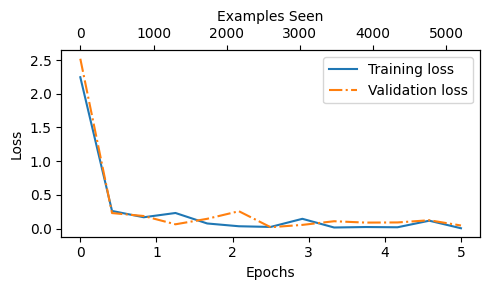

In [37]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5,3))
    
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, label=f"Validation {label}",  linestyle="-.",)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples Seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)